In [1]:
import pandas as pd
import os
import numpy as np
import random
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
kick1 = pd.read_csv('kick1.dat', sep = ' ', header = None, names = ['x', 'y', 'z'])
kick2 = pd.read_csv('kick2.dat', sep = ' ', header = None, names = ['x', 'y', 'z'])

y1 = np.array(kick1['y'])
x1 = np.array(kick1['x'])
z1 = np.array(kick1['z'])

y2 = np.array(kick2['y'])
x2 = np.array(kick2['x'])
z2 = np.array(kick2['z'])

time = np.linspace(0, 1, 20)

print(z2)

[0.145 0.177 0.172 0.167 0.192 0.219 0.213 0.223 0.25  0.244 0.233 0.269
 0.283 0.29  0.263 0.29  0.28  0.281 0.296 0.269]


In [2]:
def gradiente_ssr(t, y, b):
    if(t.size != y.size):
        raise Exception("Os vetores t e y devem ter o mesmo tamanho.")
    
    res1 = 0
    res2 = 0
    for i in range(t.size):
        res1 += b[0] + b[1] * t[i] - y[i]
    for i in range(t.size):
        res2 += (b[0] + b[1]* t[i] - y[i]) * t[i]
    return res1/t.size, res2/t.size

def gradient_descente(gradient_ssr, t, y, coeff_start, learning_rate=0.1, n_iter=50, tolerance=1e-11):
    coeff_output = coeff_start
    for _ in range(n_iter):
        diff = -learning_rate * np.array(gradient_ssr(t, y, coeff_output))
        if np.all(np.abs(diff) <= tolerance):
            print(np.abs(diff))
            print(tolerance)
            break
        coeff_output += diff
    return coeff_output

def predict_points(coefficients, time):
    lin_function = lambda b0, b1, t: b0 + b1*t
    points_array = []
    for t in time:
        points_array.append(lin_function(coefficients[0], coefficients[1], t))
    return points_array


In [3]:
def loss_mse(ys, y_bar):
    return sum((ys - y_bar)*(ys - y_bar)) / len(ys)

def eval_2nd_degree(coeffs, x):
    a = (coeffs[0]*(x*x))
    b = coeffs[1]*x
    c = coeffs[2]
    y = a+b+c
    return y
def eval_4th_degree(coeffs, x):
    a = (coeffs[0]*(x*x*x*x))
    b = (coeffs[1]*(x*x*x))
    c = (coeffs[2]*(x*x))
    d = (coeffs[3]*(x))
    e = coeffs[4]
    y = a+b+c+d+e
    return y
def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr): 
    a_s = []
    b_s = []
    c_s = []
        
    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x**2        
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y-y_bar)
        b_s.append(partial_b)
        partial_c = (y-y_bar)
        c_s.append(partial_c)
    
    num = [i for i in y_bars]
    n = len(num)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c
    
    new_model_coeffs = (a_new, b_new, c_new)
    
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)
    
    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar
def calc_gradient_4th_poly_for_GD(coeffs, inputs_x, outputs_y, lr): 
    a_s = []
    b_s = []
    c_s = []
    d_s = []
    e_s = []
        
    y_bars = eval_4th_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_2 = x**2
        x_3 = x**3
        x_4 = x**4
        partial_a = x_4 * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x_3 * (y - y_bar)
        b_s.append(partial_b)
        partial_c = x_2 * (y - y_bar)
        c_s.append(partial_c)
        partial_d = x * (y - y_bar)
        d_s.append(partial_d)
        partial_e = 0
        e_s.append(partial_e)
    
    num = [i for i in y_bars]
    n = len(num)
    
    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)
    gradient_d = (-2 / n) * sum(d_s)
    gradient_e = (-2 / n) * sum(e_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c
    d_new = coeffs[3] - lr * gradient_d
    e_new = coeffs[4] - lr * gradient_e
    
    new_model_coeffs = (a_new, b_new, c_new, d_new, e_new)
    
    new_y_bar = eval_4th_degree(new_model_coeffs, inputs_x)
    
    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

def gradient_descent(epochs, lr, x_inputs, y_outputs, polyDegree):
    losses = []
    
    if(polyDegree == 2):
        rand_coeffs_to_test = (random.randrange(-1, 0)/2, random.randrange(-1, 1)/2, y_outputs[0])
        for i in range(epochs):
            loss = calc_gradient_2nd_poly_for_GD(rand_coeffs_to_test, x_inputs, y_outputs, lr)
            rand_coeffs_to_test = loss[1]
            losses.append(loss[0])
        return loss[0], loss[1], loss[2], losses, rand_coeffs_to_test
    elif(polyDegree == 4):
        for i in range(epochs):
            rand_coeffs_to_test = (random.randrange(-1, 1)/2, random.randrange(-1, 1)/2, random.randrange(-1, 1)/2, random.randrange(-1, 1)/2, y_outputs[0])
            loss = calc_gradient_4th_poly_for_GD(rand_coeffs_to_test, x_inputs, y_outputs, lr)
            rand_coeffs_to_test = loss[1]
            losses.append(loss[0])
        return loss[0], loss[1], loss[2], losses
    else:
        raise("Grau do polinômio inválido. Escolha grau 2 ou grau 4.")
        
    


[0.10455896 0.10966233 0.11417754 0.1181046  0.1214435  0.12419425
 0.12635685 0.12793129 0.12891758 0.12931571 0.12912569 0.12834751
 0.12698118 0.12502669 0.12248405 0.11935325 0.1156343  0.1113272
 0.10643194 0.10094852]
(-0.10616191048163377, 0.1025514765067127, 0.10455895624003689)


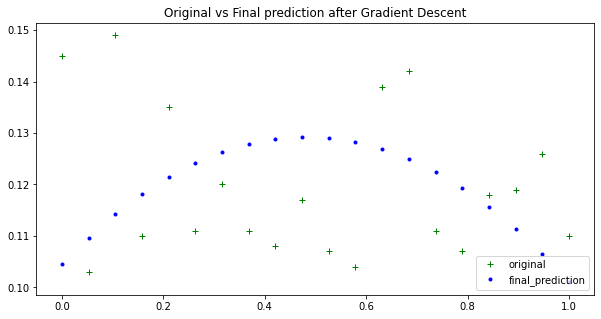

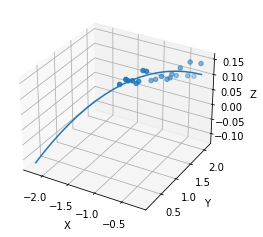

[0.12744712 0.12588529 0.12444593 0.12312905 0.12193464 0.1208627
 0.11991323 0.11908624 0.11838172 0.11779967 0.1173401  0.117003
 0.11678837 0.11669622 0.11672653 0.11687933 0.11715459 0.11755233
 0.11807254 0.11871522]
(0.02210636581524345, -0.030838270327400136, 0.12744712251300305)


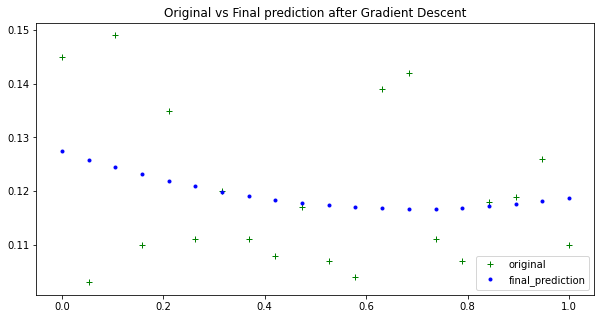

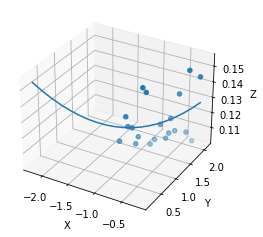

[0.12744712 0.12588529 0.12444593 0.12312905 0.12193464 0.1208627
 0.11991323 0.11908624 0.11838172 0.11779967 0.1173401  0.117003
 0.11678837 0.11669622 0.11672653 0.11687933 0.11715459 0.11755233
 0.11807254 0.11871522]
(0.02210636581524345, -0.030838270327400136, 0.12744712251300305)


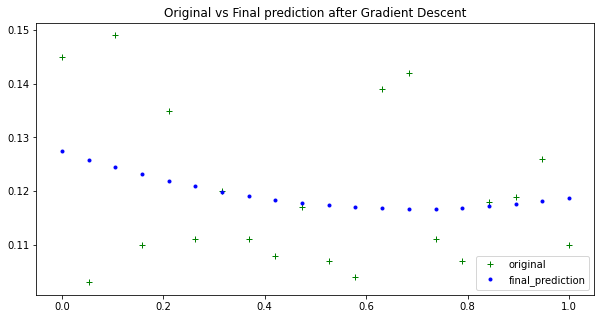

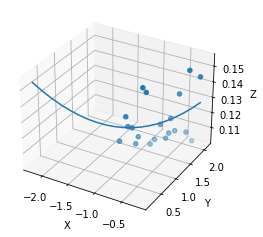

[0.12744712 0.12588529 0.12444593 0.12312905 0.12193464 0.1208627
 0.11991323 0.11908624 0.11838172 0.11779967 0.1173401  0.117003
 0.11678837 0.11669622 0.11672653 0.11687933 0.11715459 0.11755233
 0.11807254 0.11871522]
(0.02210636581524345, -0.030838270327400136, 0.12744712251300305)


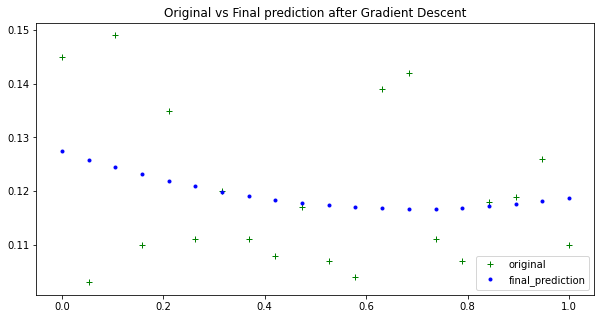

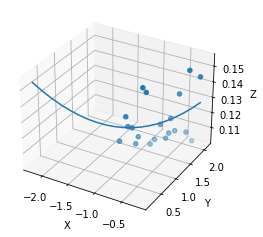

[0.10455896 0.10966233 0.11417754 0.1181046  0.1214435  0.12419425
 0.12635685 0.12793129 0.12891758 0.12931571 0.12912569 0.12834751
 0.12698118 0.12502669 0.12248405 0.11935325 0.1156343  0.1113272
 0.10643194 0.10094852]
(-0.10616191048163377, 0.1025514765067127, 0.10455895624003689)


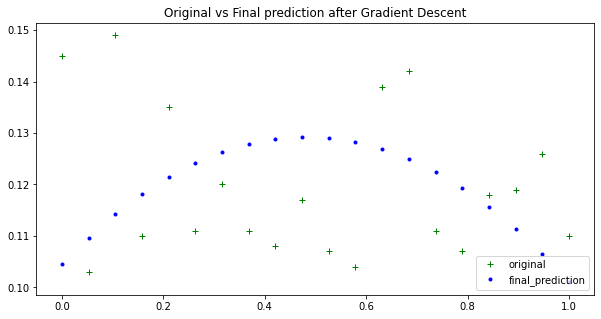

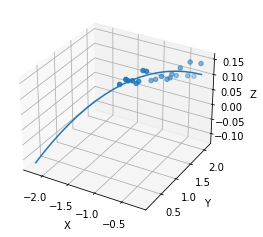

[0.12744712 0.12588529 0.12444593 0.12312905 0.12193464 0.1208627
 0.11991323 0.11908624 0.11838172 0.11779967 0.1173401  0.117003
 0.11678837 0.11669622 0.11672653 0.11687933 0.11715459 0.11755233
 0.11807254 0.11871522]
(0.02210636581524345, -0.030838270327400136, 0.12744712251300305)


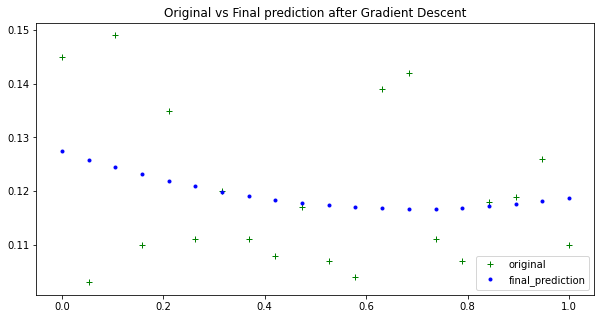

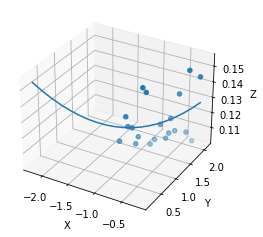

[0.12744712 0.12588529 0.12444593 0.12312905 0.12193464 0.1208627
 0.11991323 0.11908624 0.11838172 0.11779967 0.1173401  0.117003
 0.11678837 0.11669622 0.11672653 0.11687933 0.11715459 0.11755233
 0.11807254 0.11871522]
(0.02210636581524345, -0.030838270327400136, 0.12744712251300305)


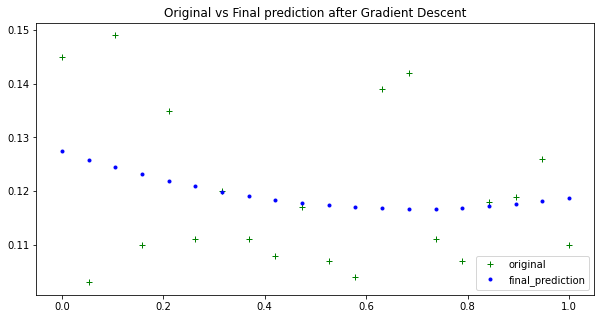

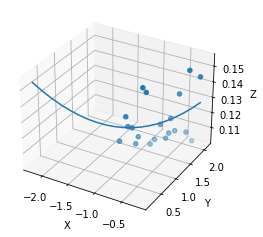

[0.12744712 0.12588529 0.12444593 0.12312905 0.12193464 0.1208627
 0.11991323 0.11908624 0.11838172 0.11779967 0.1173401  0.117003
 0.11678837 0.11669622 0.11672653 0.11687933 0.11715459 0.11755233
 0.11807254 0.11871522]
(0.02210636581524345, -0.030838270327400136, 0.12744712251300305)


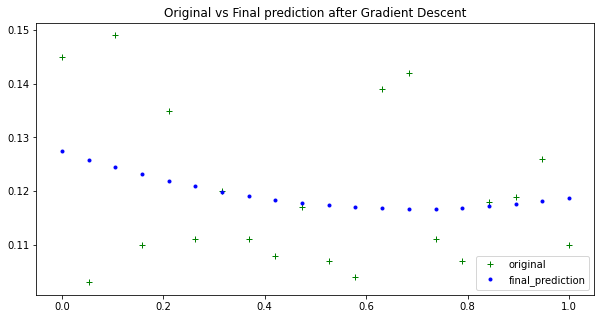

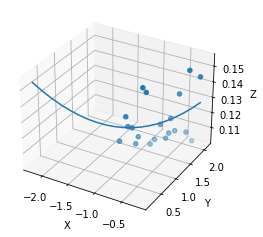

[0.10455896 0.10966233 0.11417754 0.1181046  0.1214435  0.12419425
 0.12635685 0.12793129 0.12891758 0.12931571 0.12912569 0.12834751
 0.12698118 0.12502669 0.12248405 0.11935325 0.1156343  0.1113272
 0.10643194 0.10094852]
(-0.10616191048163377, 0.1025514765067127, 0.10455895624003689)


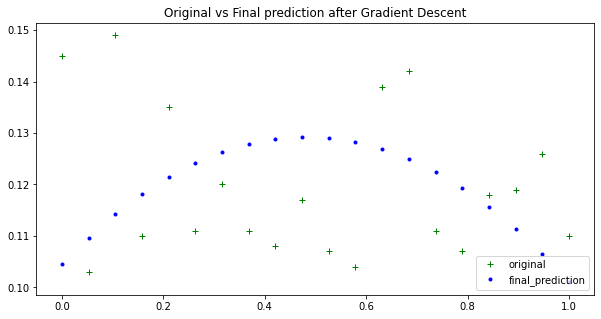

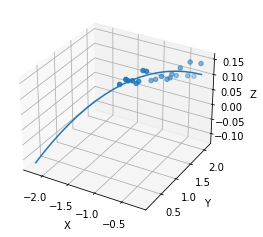

[0.10455896 0.10966233 0.11417754 0.1181046  0.1214435  0.12419425
 0.12635685 0.12793129 0.12891758 0.12931571 0.12912569 0.12834751
 0.12698118 0.12502669 0.12248405 0.11935325 0.1156343  0.1113272
 0.10643194 0.10094852]
(-0.10616191048163377, 0.1025514765067127, 0.10455895624003689)


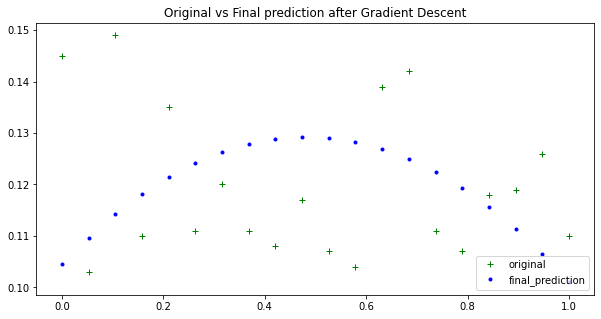

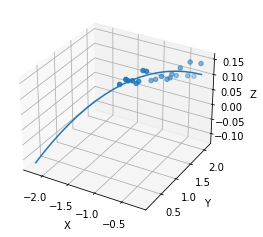

In [4]:
coeff_y1 = gradient_descente(gradiente_ssr, time, y1, coeff_start=[2.1, -.975], learning_rate=0.0000001, n_iter=100000)
coeff_x1 = gradient_descente(gradiente_ssr, time, x1, coeff_start=[-.22, -1], learning_rate=0.0000001, n_iter=100000)
for i in range(10):
    GD = gradient_descent(100000, 0.001, time, z1, 2)
    time1 = np.linspace(0, 2, 20)
    y1_predicted = predict_points(coeff_y1, time1)
    x1_predicted = predict_points(coeff_x1, time1)

    z1_predicted = eval_2nd_degree(GD[1], time1)
    #plt.figure(figsize=(20,10))
    print(GD[2])
    print(GD[1])
    plt.figure(figsize=(10,5))
    plt.plot(time, z1, 'g+', label = 'original')
    plt.plot(time, GD[2], 'b.', label = 'final_prediction')
    plt.title('Original vs Final prediction after Gradient Descent')
    plt.legend(loc="lower right")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x1, y1, z1);
    ax.plot(x1_predicted, y1_predicted, z1_predicted)
    plt.show()

[ 0.145       0.11726993  0.0863365   0.05176294  0.01311257 -0.0300512
 -0.07816489 -0.1316649  -0.19098756 -0.25656912 -0.32884571 -0.40825342
 -0.4952282  -0.59020595 -0.69362246 -0.80591344 -0.92751452 -1.05886122
 -1.20038898 -1.35253317]
(0.00047992944660128685, -0.49945198983005124, -0.4993551276279341, -0.499205986207902, 0.145)


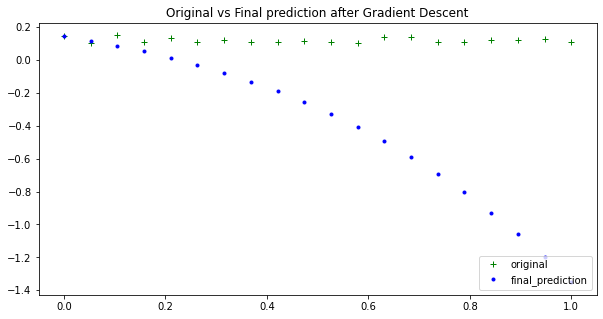

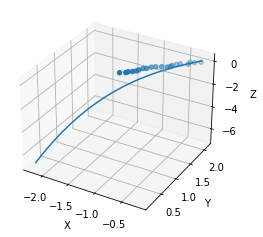

[ 0.145       0.11870784  0.09236455  0.06583241  0.03888165  0.01119049
 -0.01765486 -0.04816025 -0.08092352 -0.11663456 -0.15607526 -0.20011954
 -0.24973337 -0.30597472 -0.36999358 -0.44303198 -0.52642396 -0.62159559
 -0.73006498 -0.85344224]
(-0.499695075833211, 0.00034683505538348825, 0.0004065950657061772, -0.4995005918355445, 0.145)


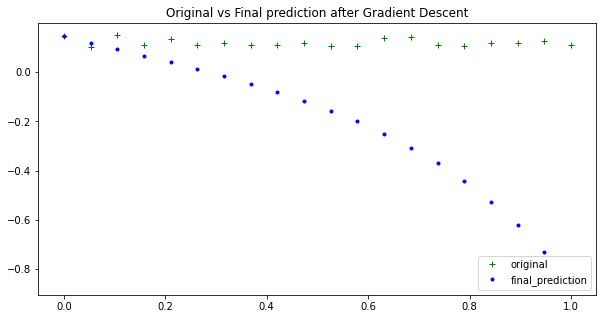

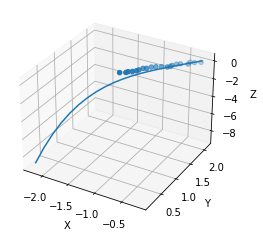

[ 0.145       0.11727627  0.08629651  0.05148599  0.01217801 -0.03238609
 -0.08305694 -0.14077712 -0.20658122 -0.28159576 -0.36703923 -0.46422211
 -0.57454683 -0.6995078  -0.84069138 -0.9997759  -1.17853169 -1.378821
 -1.60259807 -1.85190913]
(-0.4993877640092492, -0.49930670686680945, -0.49919309876721407, -0.49902155699081496, 0.145)


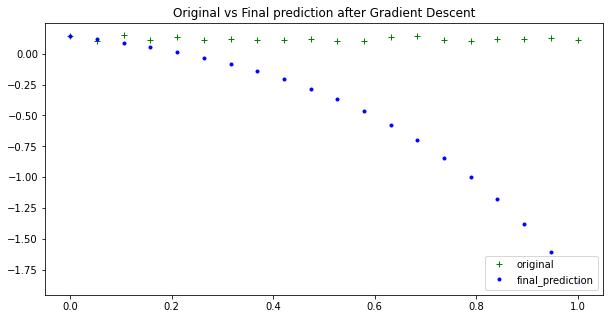

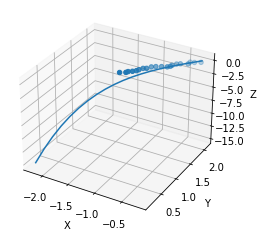

[ 0.145       0.14356695  0.13892888  0.13064877  0.11828967  0.10141467
  0.07958694  0.05236968  0.01932615 -0.01998034 -0.0659864  -0.11912861
 -0.1798435  -0.24856752 -0.32573709 -0.41178857 -0.50715825 -0.61228239
 -0.72759717 -0.85353874]
(0.00029550022951424786, -0.49966786678004393, -0.49961828552267096, 0.0004519085289400787, 0.145)


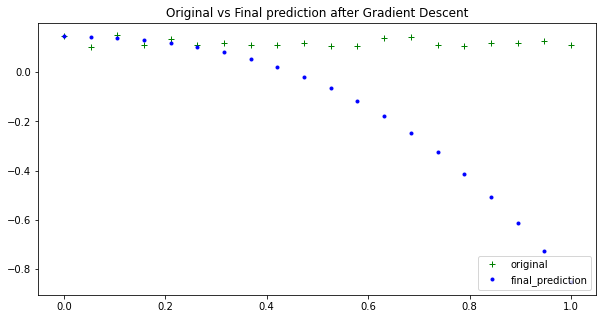

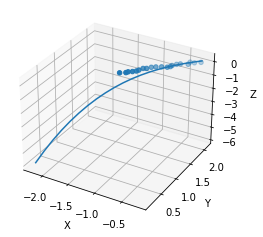

[ 0.145       0.1187015   0.09240454  0.06610936  0.03981621  0.01352538
 -0.01276282 -0.03904803 -0.06532986 -0.09160792 -0.11788174 -0.14415085
 -0.17041474 -0.19667287 -0.22292466 -0.24916951 -0.27540679 -0.30163581
 -0.32785589 -0.35406629]
(0.0001726176226394825, 0.0002015520921417116, 0.00024456620498614957, -0.4996850210526316, 0.145)


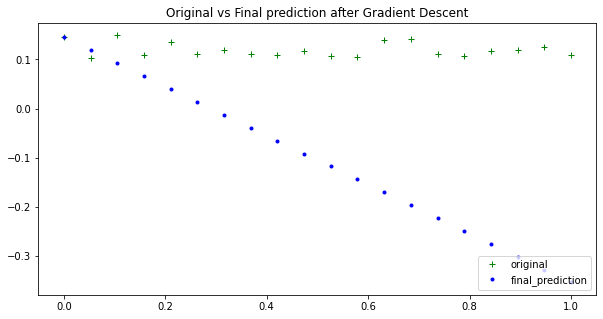

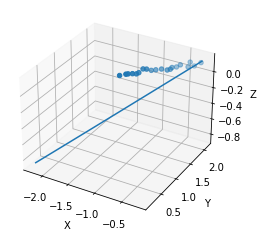

[ 0.145       0.11727627  0.08629651  0.05148599  0.01217801 -0.03238609
 -0.08305694 -0.14077712 -0.20658122 -0.28159576 -0.36703923 -0.46422211
 -0.57454683 -0.6995078  -0.84069138 -0.9997759  -1.17853169 -1.378821
 -1.60259807 -1.85190913]
(-0.4993877640092492, -0.49930670686680945, -0.49919309876721407, -0.49902155699081496, 0.145)


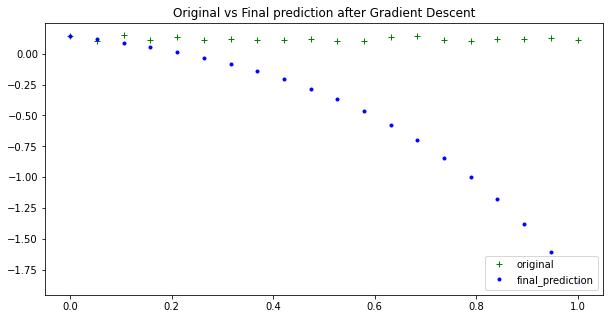

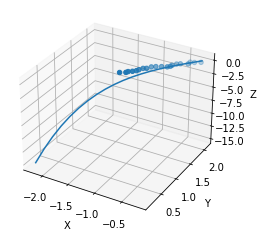

[ 0.145       0.1187015   0.09240454  0.06610936  0.03981621  0.01352538
 -0.01276282 -0.03904803 -0.06532986 -0.09160792 -0.11788174 -0.14415085
 -0.17041474 -0.19667287 -0.22292466 -0.24916951 -0.27540679 -0.30163581
 -0.32785589 -0.35406629]
(0.0001726176226394825, 0.0002015520921417116, 0.00024456620498614957, -0.4996850210526316, 0.145)


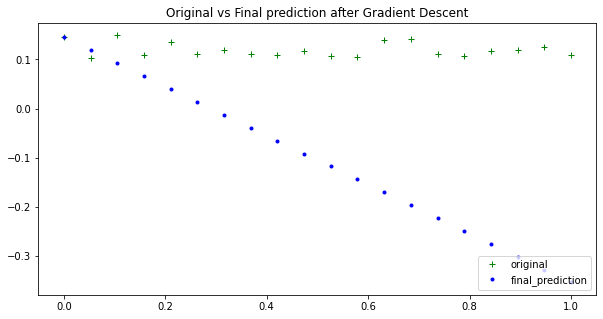

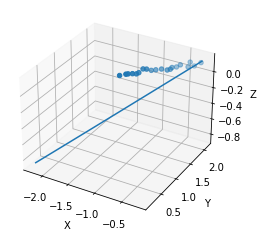

[ 0.145       0.1187015   0.09240454  0.06610936  0.03981621  0.01352538
 -0.01276282 -0.03904803 -0.06532986 -0.09160792 -0.11788174 -0.14415085
 -0.17041474 -0.19667287 -0.22292466 -0.24916951 -0.27540679 -0.30163581
 -0.32785589 -0.35406629]
(0.0001726176226394825, 0.0002015520921417116, 0.00024456620498614957, -0.4996850210526316, 0.145)


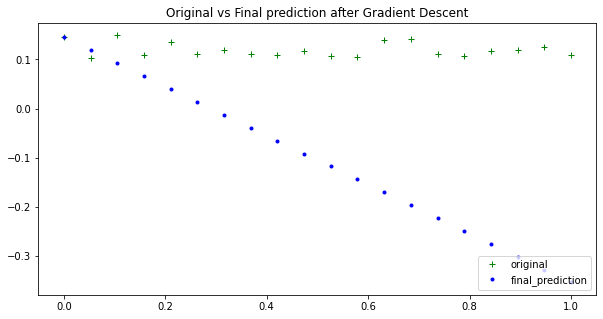

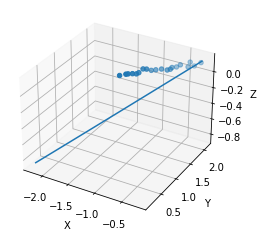

[ 0.145       0.11726993  0.0863365   0.05176294  0.01311257 -0.0300512
 -0.07816489 -0.1316649  -0.19098756 -0.25656912 -0.32884571 -0.40825342
 -0.4952282  -0.59020595 -0.69362246 -0.80591344 -0.92751452 -1.05886122
 -1.20038898 -1.35253317]
(0.00047992944660128685, -0.49945198983005124, -0.4993551276279341, -0.499205986207902, 0.145)


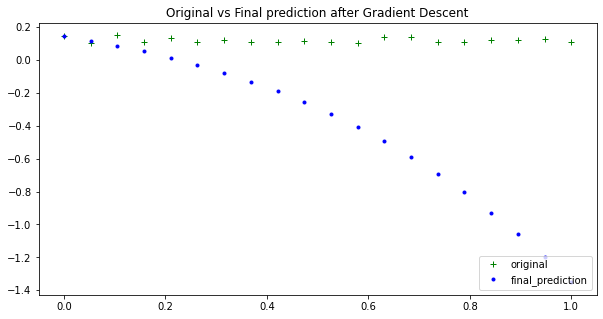

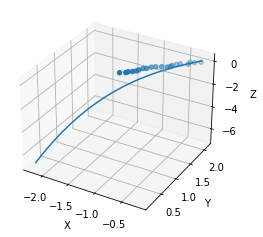

[ 0.145       0.14494386  0.14439873  0.14278943  0.13944876  0.13361748
  0.12444434  0.11098602  0.09220721  0.06698054  0.03408662 -0.00778598
 -0.06004071 -0.12417305 -0.20177052 -0.29451268 -0.40417109 -0.53260938
 -0.68178319 -0.85374019]
(-0.49973422208705626, -0.4997070130338892, 0.0003278663880563741, 0.0003731798512902755, 0.145)


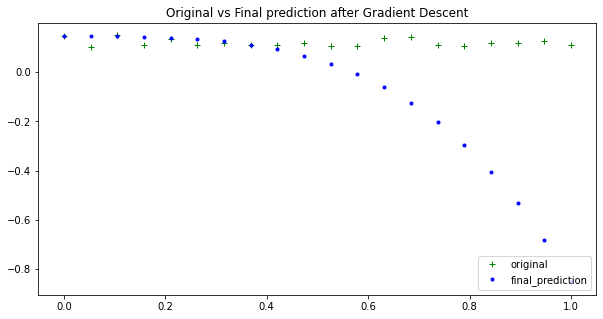

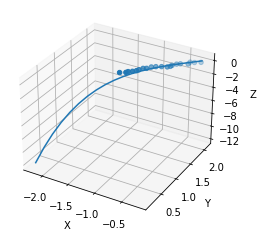

In [5]:
coeff_y1 = gradient_descente(gradiente_ssr, time, y1, coeff_start=[2.1, -.975], learning_rate=0.0000001, n_iter=100000)
coeff_x1 = gradient_descente(gradiente_ssr, time, x1, coeff_start=[-.22, -1], learning_rate=0.0000001, n_iter=100000)
for i in range(10):
    GD = gradient_descent(100000, 0.001, time, z1, 4)
    time1 = np.linspace(0, 2, 20)
    y1_predicted = predict_points(coeff_y1, time1)
    x1_predicted = predict_points(coeff_x1, time1)

    z1_predicted = eval_4th_degree(GD[1], time1)
    #plt.figure(figsize=(20,10))
    print(GD[2])
    print(GD[1])
    plt.figure(figsize=(10,5))
    plt.plot(time, z1, 'g+', label = 'original')
    plt.plot(time, GD[2], 'b.', label = 'final_prediction')
    plt.title('Original vs Final prediction after Gradient Descent')
    plt.legend(loc="lower right")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x1, y1, z1);
    ax.plot(x1_predicted, y1_predicted, z1_predicted)
    plt.show()

[0.20560515 0.20831396 0.21119571 0.21425038 0.21747799 0.22087852
 0.22445199 0.22819838 0.2321177  0.23620995 0.24047513 0.24491324
 0.24952428 0.25430825 0.25926515 0.26439497 0.26969773 0.27517342
 0.28082203 0.28664358]
(0.03121375441565981, 0.04982467499175866, 0.20560514850099496)


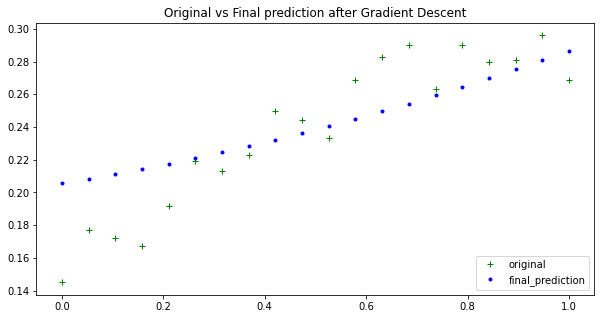

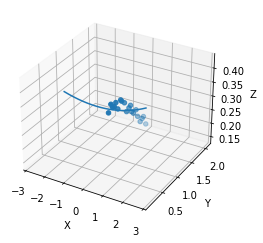

[0.15447987 0.16969414 0.18386819 0.197002   0.20909559 0.22014895
 0.23016208 0.23913498 0.24706766 0.2539601  0.25981232 0.26462431
 0.26839607 0.2711276  0.2728189  0.27346998 0.27308082 0.27165144
 0.26918183 0.26567199]
(-0.18776125921026068, 0.29895338081156, 0.15447986550265388)


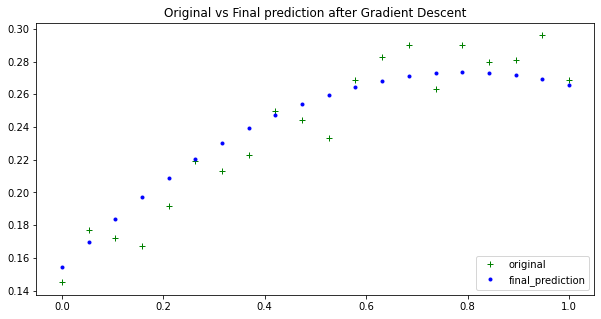

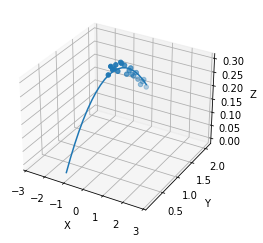

[0.20560515 0.20831396 0.21119571 0.21425038 0.21747799 0.22087852
 0.22445199 0.22819838 0.2321177  0.23620995 0.24047513 0.24491324
 0.24952428 0.25430825 0.25926515 0.26439497 0.26969773 0.27517342
 0.28082203 0.28664358]
(0.03121375441565981, 0.04982467499175866, 0.20560514850099496)


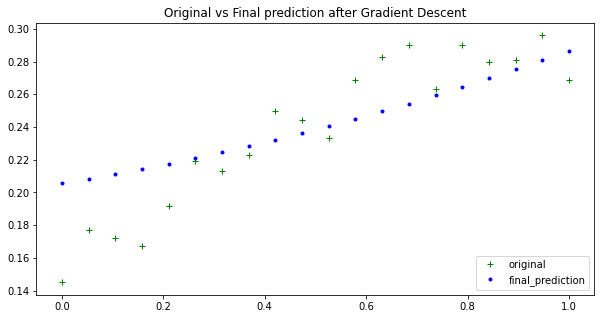

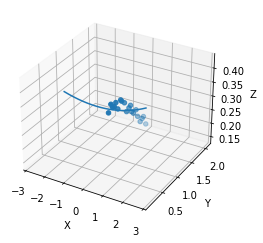

[0.20560515 0.20831396 0.21119571 0.21425038 0.21747799 0.22087852
 0.22445199 0.22819838 0.2321177  0.23620995 0.24047513 0.24491324
 0.24952428 0.25430825 0.25926515 0.26439497 0.26969773 0.27517342
 0.28082203 0.28664358]
(0.03121375441565981, 0.04982467499175866, 0.20560514850099496)


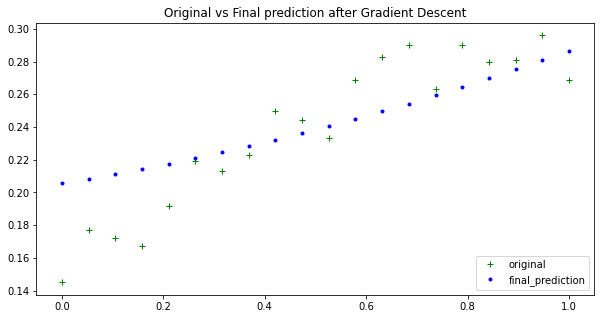

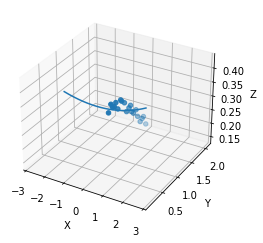

[0.15447987 0.16969414 0.18386819 0.197002   0.20909559 0.22014895
 0.23016208 0.23913498 0.24706766 0.2539601  0.25981232 0.26462431
 0.26839607 0.2711276  0.2728189  0.27346998 0.27308082 0.27165144
 0.26918183 0.26567199]
(-0.18776125921026068, 0.29895338081156, 0.15447986550265388)


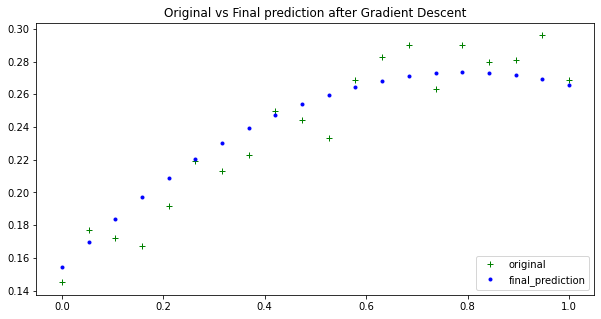

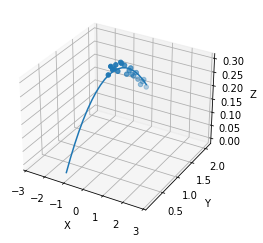

[0.20560515 0.20831396 0.21119571 0.21425038 0.21747799 0.22087852
 0.22445199 0.22819838 0.2321177  0.23620995 0.24047513 0.24491324
 0.24952428 0.25430825 0.25926515 0.26439497 0.26969773 0.27517342
 0.28082203 0.28664358]
(0.03121375441565981, 0.04982467499175866, 0.20560514850099496)


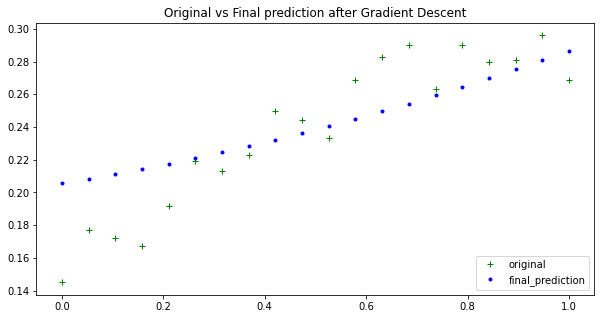

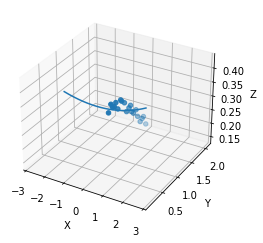

[0.20560515 0.20831396 0.21119571 0.21425038 0.21747799 0.22087852
 0.22445199 0.22819838 0.2321177  0.23620995 0.24047513 0.24491324
 0.24952428 0.25430825 0.25926515 0.26439497 0.26969773 0.27517342
 0.28082203 0.28664358]
(0.03121375441565981, 0.04982467499175866, 0.20560514850099496)


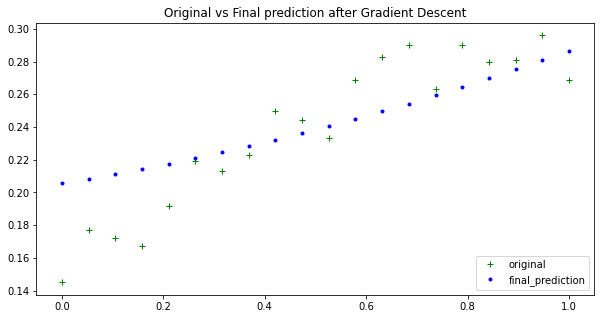

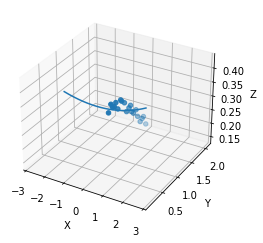

[0.15447987 0.16969414 0.18386819 0.197002   0.20909559 0.22014895
 0.23016208 0.23913498 0.24706766 0.2539601  0.25981232 0.26462431
 0.26839607 0.2711276  0.2728189  0.27346998 0.27308082 0.27165144
 0.26918183 0.26567199]
(-0.18776125921026068, 0.29895338081156, 0.15447986550265388)


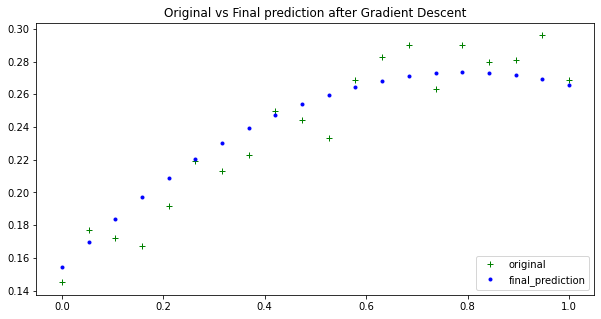

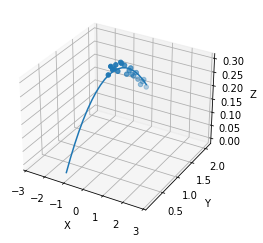

[0.15447987 0.16969414 0.18386819 0.197002   0.20909559 0.22014895
 0.23016208 0.23913498 0.24706766 0.2539601  0.25981232 0.26462431
 0.26839607 0.2711276  0.2728189  0.27346998 0.27308082 0.27165144
 0.26918183 0.26567199]
(-0.18776125921026068, 0.29895338081156, 0.15447986550265388)


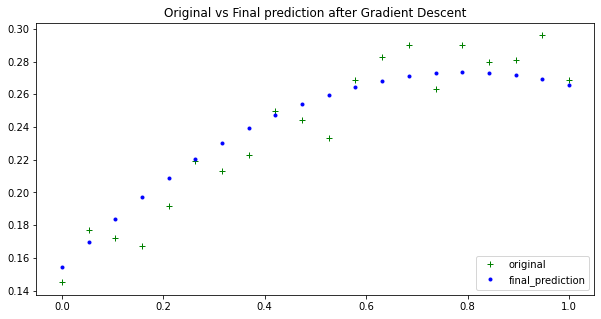

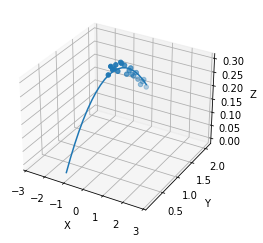

[0.20560515 0.20831396 0.21119571 0.21425038 0.21747799 0.22087852
 0.22445199 0.22819838 0.2321177  0.23620995 0.24047513 0.24491324
 0.24952428 0.25430825 0.25926515 0.26439497 0.26969773 0.27517342
 0.28082203 0.28664358]
(0.03121375441565981, 0.04982467499175866, 0.20560514850099496)


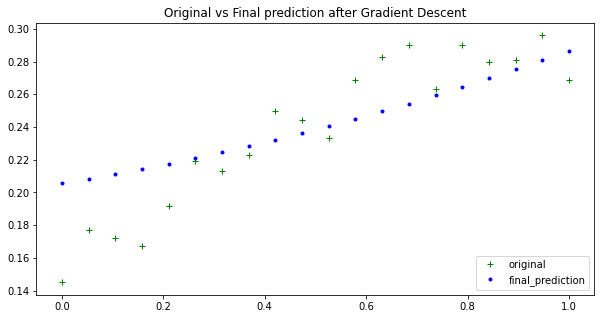

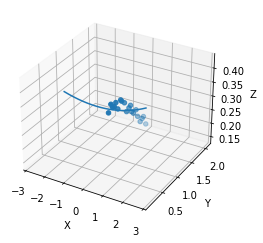

In [6]:
coeff_y2 = gradient_descente(gradiente_ssr, time, y2, coeff_start=[y2[0], -.975], learning_rate=0.0000001, n_iter=100000)
coeff_x2 = gradient_descente(gradiente_ssr, time, x2, coeff_start=[x2[0], -.5], learning_rate=0.0000001, n_iter=100000)
for i in range(10):
    GD = gradient_descent(100000, 0.0001, time, z2, 2)
    time2 = np.linspace(0, 2, 20)
    y2_predicted = predict_points(coeff_y2, time2)
    x2_predicted = predict_points(coeff_x2, time2)

    z2_predicted = eval_2nd_degree(GD[1], time2)
    #plt.figure(figsize=(20,10))
    print(GD[2])
    print(GD[1])
    plt.figure(figsize=(10,5))
    plt.plot(time, z2, 'g+', label = 'original')
    plt.plot(time, GD[2], 'b.', label = 'final_prediction')
    plt.title('Original vs Final prediction after Gradient Descent')
    plt.legend(loc="lower right")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.set_xlim3d(-3, 3)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x2, y2, z2);
    ax.plot(x2_predicted, y2_predicted, z2_predicted)
    plt.show()

[ 0.145       0.14354535  0.13888354  0.13057725  0.11818914  0.10128189
  0.07941818  0.05216071  0.01907218 -0.02028471 -0.06634725 -0.11955271
 -0.18033838 -0.24914152 -0.32639939 -0.41254924 -0.50802833 -0.61327389
 -0.72872317 -0.85481338]
(3.6501937608310485e-05, -0.4999584202528695, -0.49995123157165766, 5.977348447295524e-05, 0.145)


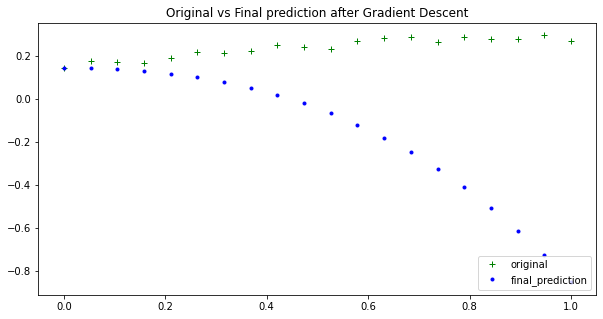

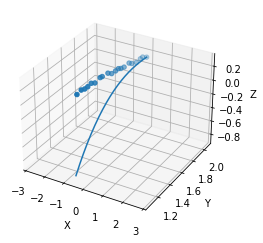

[ 0.145       0.14354253  0.1388243   0.13026986  0.11721171  0.09889026
  0.07445387  0.04295881  0.00336928 -0.04544259 -0.10469672 -0.17570513
 -0.2598719  -0.35869318 -0.47375719 -0.60674423 -0.75942665 -0.9336689
 -1.13142748 -1.35475097]
(-0.4999502674079767, -0.49994389195654537, -0.49993502868558565, 7.821640618165913e-05, 0.145)


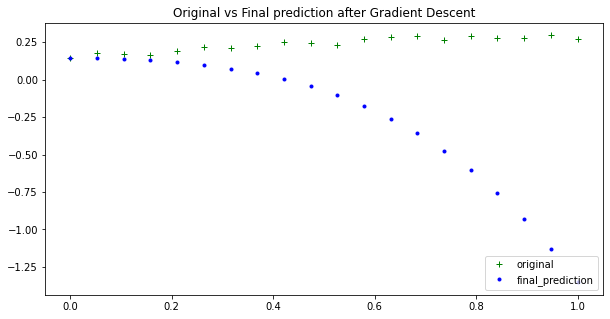

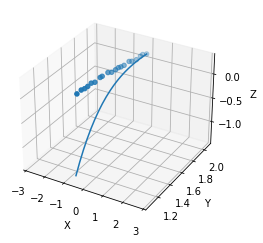

[ 0.145       0.14361424  0.13940497  0.13223414  0.12187157  0.10799506
  0.0901903   0.06795092  0.04067848  0.00768245 -0.03181974 -0.07870278
 -0.1339334  -0.19857042 -0.27376472 -0.36075927 -0.46088909 -0.57558131
 -0.70635511 -0.85482173]
(-0.4999647957043009, 3.9905157382640996e-05, -0.49995347160729436, 5.662871118238811e-05, 0.145)


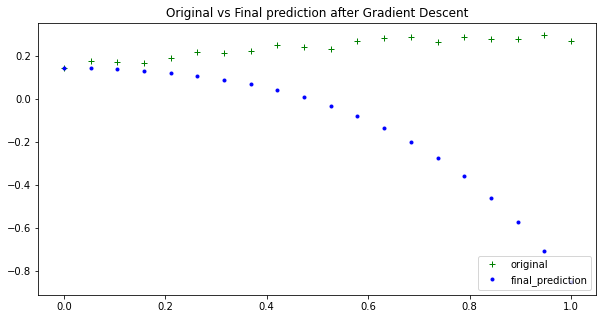

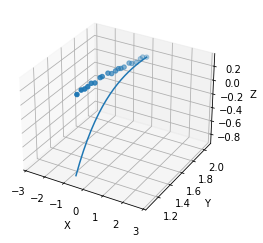

[0.145      0.14500065 0.14500136 0.14500212 0.14500296 0.14500388
 0.1450049  0.14500601 0.14500725 0.14500861 0.14501012 0.14501179
 0.14501365 0.1450157  0.14501797 0.14502047 0.14502323 0.14502628
 0.14502963 0.14503331]
(5.770755212130048e-06, 6.933939349759441e-06, 8.737811634349032e-06, 1.1870000000000003e-05, 0.145)


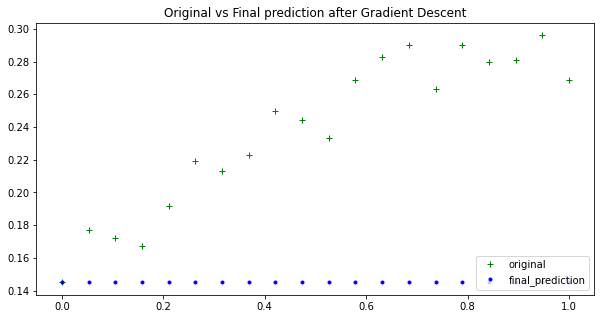

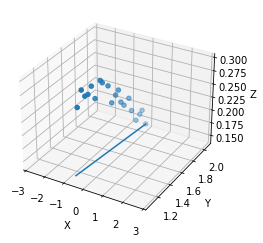

[ 0.145       0.14499783  0.14494211  0.14469473  0.14402553  0.14261226
  0.14004059  0.13580411  0.12930434  0.11985073  0.10666065  0.08885937
  0.06548012  0.03546403 -0.00233984 -0.04917452 -0.10637509 -0.17536873
 -0.25767468 -0.35490428]
(-0.4999809985903729, 2.1462235673937104e-05, 2.4940697706351805e-05, 3.0312921708703895e-05, 0.145)


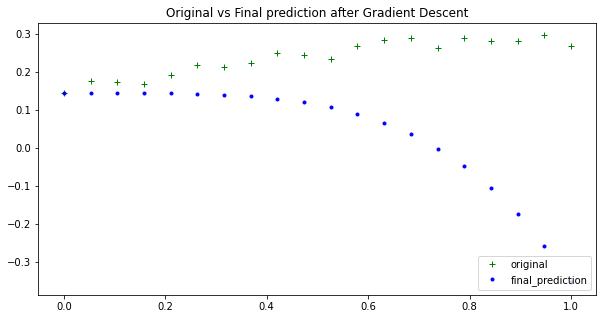

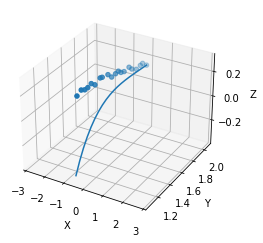

[ 0.145       0.11730314  0.08683656  0.05360031  0.01759445 -0.02118096
 -0.06272584 -0.10704011 -0.15412367 -0.20397644 -0.25659831 -0.31198916
 -0.37014888 -0.43107733 -0.4947744  -0.56123992 -0.63047377 -0.70247577
 -0.77724576 -0.85478358]
(4.041656299283671e-05, 4.6964556057734356e-05, -0.49994335870389267, -0.4999276036842105, 0.145)


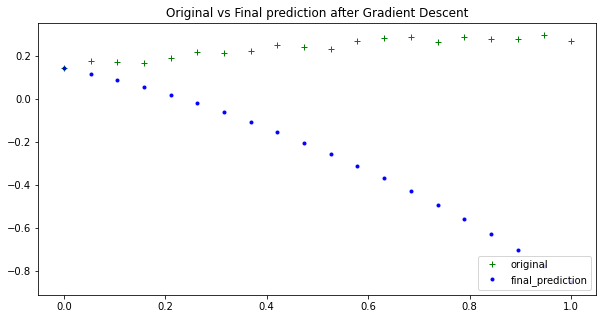

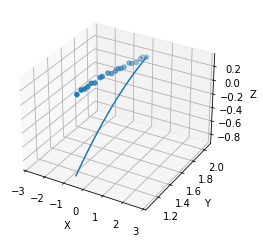

[ 0.145       0.14354535  0.13888354  0.13057725  0.11818914  0.10128189
  0.07941818  0.05216071  0.01907218 -0.02028471 -0.06634725 -0.11955271
 -0.18033838 -0.24914152 -0.32639939 -0.41254924 -0.50802833 -0.61327389
 -0.72872317 -0.85481338]
(3.6501937608310485e-05, -0.4999584202528695, -0.49995123157165766, 5.977348447295524e-05, 0.145)


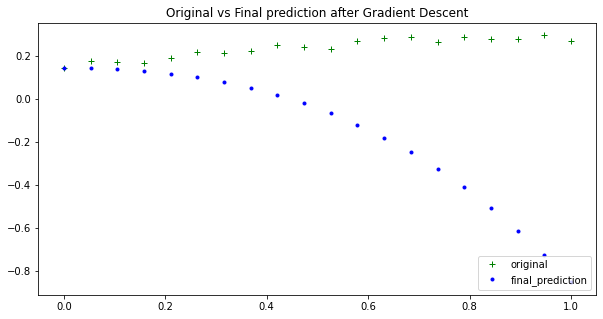

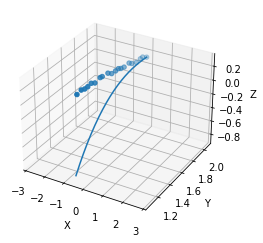

[ 0.145       0.14492612  0.14436143  0.14273046  0.13936567  0.13350747
  0.12430416  0.110812    0.09199514  0.06672569  0.03378367 -0.00814298
 -0.06045838 -0.12465873 -0.20233232 -0.29515948 -0.40491265 -0.53345632
 -0.68274706 -0.85483352]
(-0.4999664702940487, -0.49996233487825403, 4.33836194150557e-05, 5.190061670797491e-05, 0.145)


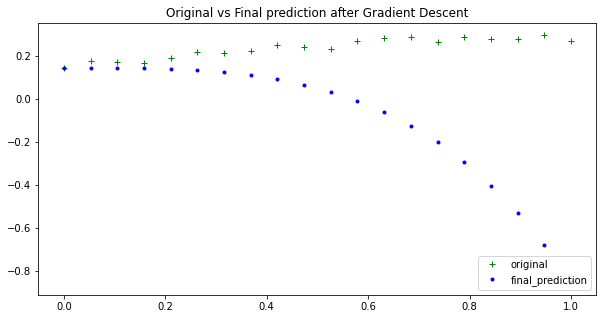

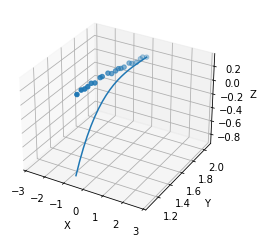

[ 0.145       0.14354535  0.13888354  0.13057725  0.11818914  0.10128189
  0.07941818  0.05216071  0.01907218 -0.02028471 -0.06634725 -0.11955271
 -0.18033838 -0.24914152 -0.32639939 -0.41254924 -0.50802833 -0.61327389
 -0.72872317 -0.85481338]
(3.6501937608310485e-05, -0.4999584202528695, -0.49995123157165766, 5.977348447295524e-05, 0.145)


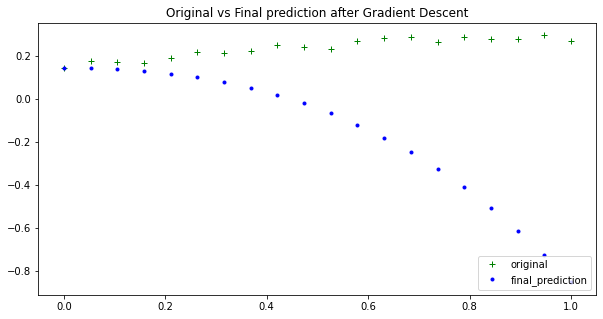

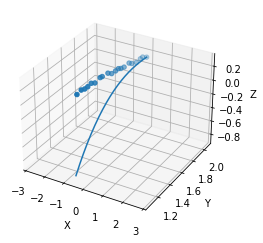

[ 0.145       0.11722862  0.08619664  0.05132865  0.01195716 -0.03267738
 -0.08342657 -0.14123412 -0.20713578 -0.28225936 -0.36782476 -0.46514393
 -0.5756209  -0.70075176 -0.84212468 -1.00141988 -1.18040965 -1.38095836
 -1.60502245 -1.85465041]
(-0.49993182448626805, -0.4999223042615461, -0.499908712896112, -0.49988757306750253, 0.145)


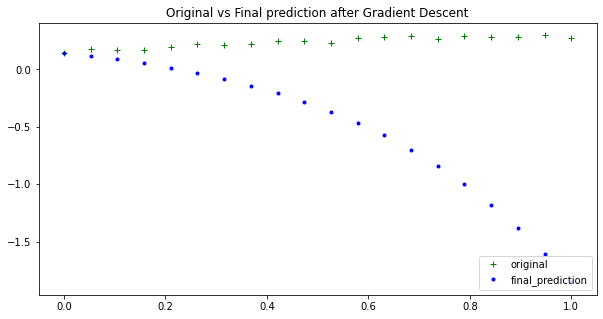

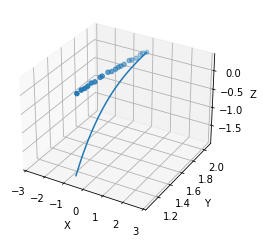

In [8]:
coeff_y2 = gradient_descente(gradiente_ssr, time, y2, coeff_start=[y2[0], -.975], learning_rate=0.0000001, n_iter=100000)
coeff_x2 = gradient_descente(gradiente_ssr, time, x2, coeff_start=[x2[0], -.5], learning_rate=0.0000001, n_iter=100000)
for i in range(10):
    GD = gradient_descent(100000, 0.0001, time, z2, 4)
    time2 = np.linspace(0, 1, 20)
    y2_predicted = predict_points(coeff_y2, time2)
    x2_predicted = predict_points(coeff_x2, time2)

    z2_predicted = eval_4th_degree(GD[1], time2)
    #plt.figure(figsize=(20,10))
    print(GD[2])
    print(GD[1])
    plt.figure(figsize=(10,5))
    plt.plot(time, z2, 'g+', label = 'original')
    plt.plot(time, GD[2], 'b.', label = 'final_prediction')
    plt.title('Original vs Final prediction after Gradient Descent')
    plt.legend(loc="lower right")
    plt.show()

    ax = plt.axes(projection='3d')
    ax.set_xlim3d(-3, 3)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.scatter3D(x2, y2, z2);
    ax.plot(x2_predicted, y2_predicted, z2_predicted)
    plt.show()